# Austin Crime and Property Analysis

### Over time, does a change in crime, imapct housing prices in Austin? 

## Null Hypothesis
* There is no corelation between %change in crime data & %change in home prices. If crime increases within zipcode, housing price doesn't decrease in that specific zipcode.

## Hypothesis
* An increase in crime, over a period, will negatively impact home prices in an Austin zip code.  Conversely, a decrease in crime, over a period, will positively impact home prices in an Austin zip code.

### Datasources
* US Cencus Data (Pupulation by zipcode)
* MLS listing data (zipcode, listing date, listing price)
* austintexas.gov (zipcode, crime type, occurance date)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import linregress

## Read Crime data

In [3]:
perc_chg_pop_crime_2015to2018 = pd.read_csv("Datasets/AustinCrimeDataset/perc_chg_pop_crime_2015to2018.csv")
perc_chg_pop_crime_2015to2018.set_index("ZipCode", inplace=True)
perc_chg_pop_crime_2015to2018.head()

,CrimePerPop2015,CrimePerPop2016,CrimePerPop2017,CrimePerPop2018
ZipCode,,,,
78701,NaN,NaN,NaN,-12.482595
78702,NaN,NaN,NaN,-5.553800
78703,NaN,NaN,NaN,-8.826972
78704,NaN,NaN,NaN,-7.016709
78705,NaN,NaN,NaN,-29.603636


## Read Property price data

In [4]:
perc_change_listing_2015_2018 = pd.read_csv("Datasets/AustinHomePrice/PerChgPriceListing.csv")
perc_change_listing_2015_2018.set_index("ZipCode", inplace=True)
perc_change_listing_2015_2018.head()

,2015,2018
ZipCode,,
78681,NaN,16.919933
78702,NaN,17.475000
78703,NaN,11.121951
78704,NaN,16.747289
78705,NaN,8.320611


In [5]:
# Merge two dataframes percentage change of crime per 1000 population(perc_chg_pop_crime_2015to2018) and percentage change in property price(perc_change_listing_2015_2018)
per_chg_crime_price_merge = pd.merge(perc_chg_pop_crime_2015to2018, perc_change_listing_2015_2018, on='ZipCode')
per_chg_crime_price_merge.columns = ['CrimePerPop2015', 'CrimePerPop2016', 'CrimePerPop2017', \
                      'CrimePerPop2018', '2015', '2018']
per_chg_crime_price_merge = per_chg_crime_price_merge[['CrimePerPop2018', '2018']]
per_chg_crime_price_merge.head()

,CrimePerPop2018,2018
ZipCode,,
78702,-5.553800,17.475000
78703,-8.826972,11.121951
78704,-7.016709,16.747289
78705,-29.603636,8.320611
78717,29.362962,13.913751


p-value is: 0.435616590620837
r-value is: -0.13822978751317572
r-square is: 0.01910747415593771


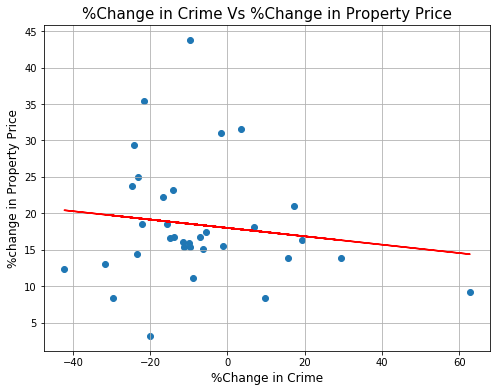

In [6]:
# Scatter plot to show the relationship between %change in crime with %change in property price.
x = per_chg_crime_price_merge["CrimePerPop2018"]
y = per_chg_crime_price_merge["2018"]
stats = linregress(x,y)

m = stats.slope
b = stats.intercept
r_value = stats.rvalue
r_square = r_value**2
print(f"p-value is: {stats.pvalue}")
print(f"r-value is: {stats.rvalue}")
print(f"r-square is: {r_square}")
plt.figure(figsize = (8,6))
plt.scatter(x,y)
plt.plot(x, m*x+b, color = "red")

plt.xlabel("%Change in Crime", fontsize=12)
plt.ylabel("%change in Property Price", fontsize=12)
plt.title("%Change in Crime Vs %Change in Property Price", fontsize=15)
plt.grid()
plt.savefig("images/CrimeVsPropertyScatterPlt.png")
plt.show()

# Observations


* Based on scatterplot and derived r-square value, it does not appear that crime data has a significant influence on home prices in Austin. There is no corelation between the two.
* Higher p-value indicates that Null Hypothesis (no corelation between the two variables i.e. crime data & home prices) is true.
* Other factors such as neighborhood location, schools, walkability, neighborhood character, property taxes and long-term value may be more important.
